# 선형회귀

현대 중공업과 계약을 맺어 일부 선박에 대한 예측 모델을 구축하게됐습니다. 현대 중공업은 세계 최대의 선박 제조업체 중 하나로 유람선을 제작하고 있습니다.
당신은 선박에 필요한 선원 수를 정확하게 예측할 수 있도록 울산에있는 본사에 도착했습니다.
그들은 현재 새로운 선박을 건조하고 있으며 예측 모델을 만들고, 이를 사용하여 선박에 필요한 승무원 수를 예측하기를 원합니다.

지금까지의 데이터는 다음과 같습니다.

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
위 데이터는 "cruise_ship_info.csv"라는 csv 파일에 저장됩니다. 귀하의 임무는 향후 선박에 필요한 선원 수를 예측하는 데 도움이되는 회귀 모델을 만드는 것입니다. 고객은 또한 특정 크루즈 라인이 허용되는 승무원 수에 차이가 있음을 발견 했으므로 분석에 포함하는 것이 가장 중요한 기능이라고 언급했습니다!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
df = pd.read_csv("./data/cruise_ship_info_example.csv")
df = df.iloc[:, 1:]

In [3]:
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,NaN
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,NaN
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [4]:
df = df.drop("Ship_name", axis = 1)

In [5]:
df.shape

(158, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cruise_line        158 non-null    object 
 1   Age                158 non-null    int64  
 2   Tonnage            158 non-null    float64
 3   passengers         158 non-null    float64
 4   length             158 non-null    float64
 5   cabins             158 non-null    float64
 6   passenger_density  158 non-null    float64
 7   crew               110 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.0+ KB


- crew 컬럼에 48개 결측치 존재

In [7]:
df.dtypes

Cruise_line           object
Age                    int64
Tonnage              float64
passengers           float64
length               float64
cabins               float64
passenger_density    float64
crew                 float64
dtype: object

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


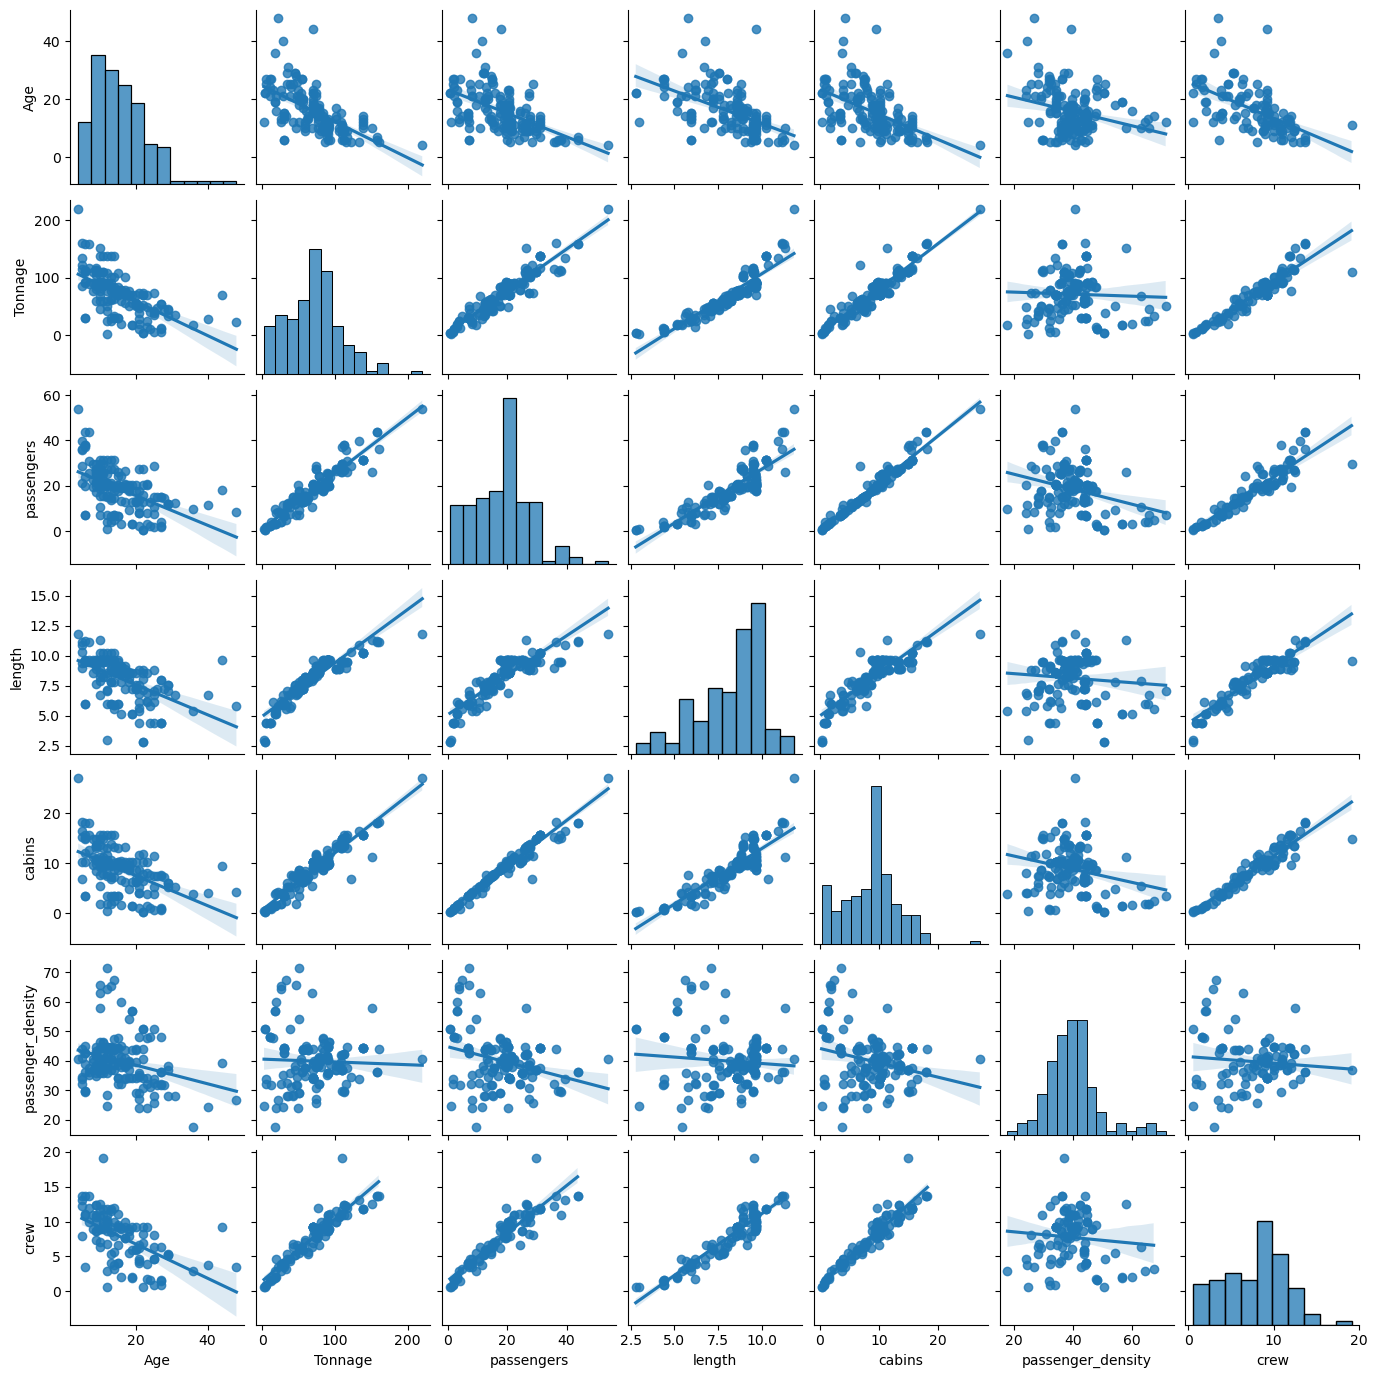

In [8]:
sns.pairplot(df.drop("Cruise_line", axis = 1), kind='reg', height = 2)

In [9]:
df_corr = df.iloc[:, 1:].corr()
df_corr

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.554700
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.933967
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.920679
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.918819
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950220
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.094822
crew,-0.554700,0.933967,0.920679,0.918819,0.950220,-0.094822,1.000000


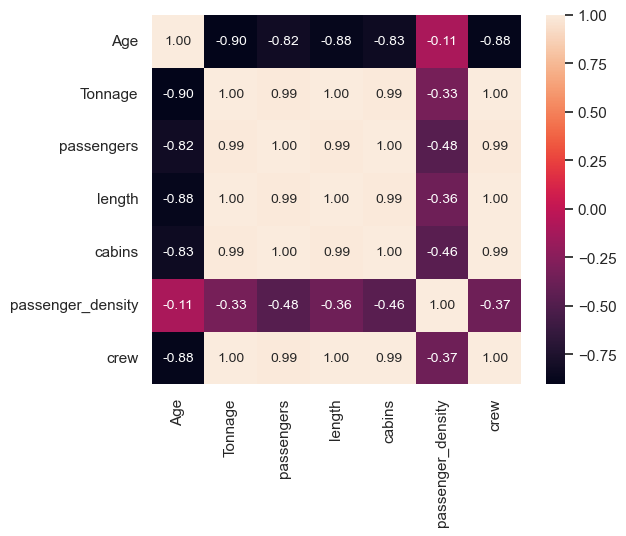

In [10]:
corr_mat = np.corrcoef(df_corr.values.T)
sns.set()
full_mat = sns.heatmap(corr_mat, cbar = True, annot = True, square = True, fmt = ".2f",
                      annot_kws = {"size" : 10}, yticklabels = df_corr,
                      xticklabels = df_corr)
plt.show()

- **Age와 passenger_density의 상관관계가 낮음**

# 데이터 전처리

## "Cruise_line" 원핫인코딩

In [11]:
df["Cruise_line"].unique()

array(['Azamara', 'Carnival', 'Celebrity', 'Costa', 'Crystal', 'Cunard',
       'Disney', 'Holland_American', 'MSC', 'Norwegian', 'Oceania',
       'Orient', 'P&O', 'Princess', 'Regent_Seven_Seas',
       'Royal_Caribbean', 'Seabourn', 'Silversea', 'Star', 'Windstar'],
      dtype=object)

In [12]:
# Cruise_line 원핫인코딩
onehot_cruise_line = pd.get_dummies(df["Cruise_line"], prefix = "cl")
onehot_cruise_line.head()

,cl_Azamara,cl_Carnival,cl_Celebrity,cl_Costa,cl_Crystal,cl_Cunard,cl_Disney,cl_Holland_American,cl_MSC,cl_Norwegian,cl_Oceania,cl_Orient,cl_P&O,cl_Princess,cl_Regent_Seven_Seas,cl_Royal_Caribbean,cl_Seabourn,cl_Silversea,cl_Star,cl_Windstar
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
ohe = OneHotEncoder()

In [14]:
onehot_cl = np.array(df["Cruise_line"])

In [15]:
onehot_cl = np.reshape(onehot_cl, (-1, 1))

In [16]:
cl_Cruise_line = ohe.fit_transform(onehot_cl)

In [17]:
ohe.get_feature_names_out()

array(['x0_Azamara', 'x0_Carnival', 'x0_Celebrity', 'x0_Costa',
       'x0_Crystal', 'x0_Cunard', 'x0_Disney', 'x0_Holland_American',
       'x0_MSC', 'x0_Norwegian', 'x0_Oceania', 'x0_Orient', 'x0_P&O',
       'x0_Princess', 'x0_Regent_Seven_Seas', 'x0_Royal_Caribbean',
       'x0_Seabourn', 'x0_Silversea', 'x0_Star', 'x0_Windstar'],
      dtype=object)

In [18]:
cl_Cruise_line

<158x20 sparse matrix of type '<class 'numpy.float64'>'
	with 158 stored elements in Compressed Sparse Row format>

In [19]:
ohe_cl_df = pd.DataFrame(cl_Cruise_line.toarray(), columns = ohe.get_feature_names_out())

In [20]:
ohe_cl_df.head()

,x0_Azamara,x0_Carnival,x0_Celebrity,x0_Costa,x0_Crystal,x0_Cunard,x0_Disney,x0_Holland_American,x0_MSC,x0_Norwegian,x0_Oceania,x0_Orient,x0_P&O,x0_Princess,x0_Regent_Seven_Seas,x0_Royal_Caribbean,x0_Seabourn,x0_Silversea,x0_Star,x0_Windstar
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
ohe_cl_df.shape

(158, 20)

In [22]:
df = pd.concat([df, ohe_cl_df], axis = 1)

In [23]:
df.head()

,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew,x0_Azamara,x0_Carnival,...,x0_Oceania,x0_Orient,x0_P&O,x0_Princess,x0_Regent_Seven_Seas,x0_Royal_Caribbean,x0_Seabourn,x0_Silversea,x0_Star,x0_Windstar
0,Azamara,6,30.277,6.94,5.94,3.55,42.64,NaN,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Carnival,26,47.262,14.86,7.22,7.43,31.80,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df = df.drop("Cruise_line", axis = 1)

In [25]:
df.head()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew,x0_Azamara,x0_Carnival,x0_Celebrity,...,x0_Oceania,x0_Orient,x0_P&O,x0_Princess,x0_Regent_Seven_Seas,x0_Royal_Caribbean,x0_Seabourn,x0_Silversea,x0_Star,x0_Windstar
0,6,30.277,6.94,5.94,3.55,42.64,NaN,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,30.277,6.94,5.94,3.55,42.64,3.55,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26,47.262,14.86,7.22,7.43,31.80,NaN,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,110.000,29.74,9.53,14.88,36.99,19.10,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,101.353,26.42,8.92,13.21,38.36,10.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
use_df = df[df["crew"].notnull()]
val_df = df[df["crew"].isnull()]

In [66]:
use_df.head()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew,x0_Azamara,x0_Carnival,x0_Celebrity,...,x0_Oceania,x0_Orient,x0_P&O,x0_Princess,x0_Regent_Seven_Seas,x0_Royal_Caribbean,x0_Seabourn,x0_Silversea,x0_Star,x0_Windstar
1,6,30.277,6.94,5.94,3.55,42.64,3.55,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,110.000,29.74,9.53,14.88,36.99,19.10,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,101.353,26.42,8.92,13.21,38.36,10.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,22,70.367,20.52,8.55,10.20,34.29,9.20,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,15,70.367,20.52,8.55,10.20,34.29,9.20,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
use_df.shape

(110, 27)

In [69]:
use_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 1 to 157
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   110 non-null    int64  
 1   Tonnage               110 non-null    float64
 2   passengers            110 non-null    float64
 3   length                110 non-null    float64
 4   cabins                110 non-null    float64
 5   passenger_density     110 non-null    float64
 6   crew                  110 non-null    float64
 7   x0_Azamara            110 non-null    float64
 8   x0_Carnival           110 non-null    float64
 9   x0_Celebrity          110 non-null    float64
 10  x0_Costa              110 non-null    float64
 11  x0_Crystal            110 non-null    float64
 12  x0_Cunard             110 non-null    float64
 13  x0_Disney             110 non-null    float64
 14  x0_Holland_American   110 non-null    float64
 15  x0_MSC                110 no

In [70]:
use_df.dtypes

Age                       int64
Tonnage                 float64
passengers              float64
length                  float64
cabins                  float64
passenger_density       float64
crew                    float64
x0_Azamara              float64
x0_Carnival             float64
x0_Celebrity            float64
x0_Costa                float64
x0_Crystal              float64
x0_Cunard               float64
x0_Disney               float64
x0_Holland_American     float64
x0_MSC                  float64
x0_Norwegian            float64
x0_Oceania              float64
x0_Orient               float64
x0_P&O                  float64
x0_Princess             float64
x0_Regent_Seven_Seas    float64
x0_Royal_Caribbean      float64
x0_Seabourn             float64
x0_Silversea            float64
x0_Star                 float64
x0_Windstar             float64
dtype: object

In [75]:
use_df.corr()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew,x0_Azamara,x0_Carnival,x0_Celebrity,...,x0_Oceania,x0_Orient,x0_P&O,x0_Princess,x0_Regent_Seven_Seas,x0_Royal_Caribbean,x0_Seabourn,x0_Silversea,x0_Star,x0_Windstar
Age,1.000000,-0.611074,-0.530998,-0.521201,-0.543746,-0.281846,-0.554700,-0.121113,-0.036082,-0.050642,...,-0.037505,0.381168,-0.063796,-0.125269,0.060058,-0.143914,0.159250,0.011277,0.027231,0.185497
Tonnage,-0.611074,1.000000,0.949099,0.935228,0.959566,0.019446,0.933967,-0.102683,0.161441,-0.020525,...,-0.179506,-0.123766,0.049402,0.185390,-0.218671,0.413097,-0.219983,-0.227814,-0.182005,-0.277506
passengers,-0.530998,0.949099,1.000000,0.900490,0.984567,-0.224288,0.920679,-0.111859,0.210294,-0.058091,...,-0.197292,-0.098688,0.066797,0.121318,-0.246599,0.453191,-0.227821,-0.259623,-0.149457,-0.279800
length,-0.521201,0.935228,0.900490,1.000000,0.919576,-0.026614,0.918819,-0.110949,0.196001,-0.018648,...,-0.193957,-0.119301,0.075194,0.157605,-0.276995,0.356818,-0.271837,-0.241712,-0.216548,-0.280645
cabins,-0.543746,0.959566,0.984567,0.919576,1.000000,-0.187582,0.950220,-0.112754,0.257313,-0.055524,...,-0.202040,-0.097579,0.056485,0.160065,-0.269374,0.397384,-0.237505,-0.269753,-0.149535,-0.293250
passenger_density,-0.281846,0.019446,-0.224288,-0.026614,-0.187582,1.000000,-0.094822,0.033783,-0.146597,-0.013993,...,0.091742,-0.149827,-0.044499,0.095287,0.268607,-0.099613,0.137193,0.395507,-0.098306,-0.036099
crew,-0.554700,0.933967,0.920679,0.918819,0.950220,-0.094822,1.000000,-0.112837,0.295399,0.008794,...,-0.176015,-0.114187,0.058192,0.173363,-0.257677,0.257984,-0.235118,-0.255631,-0.093446,-0.308813
x0_Azamara,-0.121113,-0.102683,-0.111859,-0.110949,-0.112754,0.033783,-0.112837,1.000000,-0.038060,-0.024970,...,-0.016038,-0.009174,-0.023006,-0.036578,-0.016038,-0.033517,-0.013034,-0.016038,-0.018606,-0.016038
x0_Carnival,-0.036082,0.161441,0.210294,0.196001,0.257313,-0.146597,0.295399,-0.038060,1.000000,-0.103589,...,-0.066535,-0.038060,-0.095443,-0.151744,-0.066535,-0.139047,-0.054074,-0.066535,-0.077190,-0.066535
x0_Celebrity,-0.050642,-0.020525,-0.058091,-0.018648,-0.055524,-0.013993,0.008794,-0.024970,-0.103589,1.000000,...,-0.043651,-0.024970,-0.062617,-0.099554,-0.043651,-0.091224,-0.035476,-0.043651,-0.050642,-0.043651


In [78]:
x = use_df.drop("crew", axis = 1)
y = use_df["crew"]
print(x.shape, y.shape)

(110, 26) (110,)


In [81]:
ss = StandardScaler()

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x.drop(["Age","passenger_density"], axis = 1), y, test_size = 0.3, random_state = 1)

In [86]:
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

In [87]:
lr = LinearRegression()

In [93]:
lr_fit = lr.fit(scaled_train, y_train)

In [94]:
print(lr.score(scaled_train, y_train))
print(lr.score(scaled_test, y_test))

0.942850236638078
0.9534946877075169


In [95]:
pred_test = lr.predict(scaled_test)
pred_train = lr.predict(scaled_train)

In [96]:
mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
print(mse_test)
print(mse_train)

0.4808821219773053
0.7649397103126608


In [101]:
new_val_df = val_df.drop(["crew","passenger_density", "Age"], axis = 1)

In [107]:
ns_val_df = ss.transform(new_val_df)

In [108]:
lr.predict(ns_val_df)

array([ 3.55      ,  6.757192  , 12.13360887,  6.66622357,  9.26707641,
       12.93386049, 10.19700538, 12.93858514,  9.2481866 , 10.00204892,
        7.2609984 ,  5.50473456,  9.38534   ,  9.80528069,  9.44724803,
        6.06012559,  5.38613608,  8.53339572,  5.86688321,  5.39229726,
        6.45506305,  8.52190499,  7.20930938,  4.53402602,  7.20458472,
        8.88184029,  8.87322947,  7.40852866, 12.03835827, 11.16645239,
        2.9380116 ,  4.73248357,  3.07582744,  8.17114251,  4.9960881 ,
        7.80491927,  7.07763985,  8.4301187 , 12.40205492, 20.87731028,
        7.50901836,  8.17114251,  6.78941436, 12.40205492,  1.6       ,
        2.78395394,  1.72037475,  8.3025197 ])